<u><b>Explanation of Business Readiness Score Calculation</b></u>

The Business Readiness Score is calculated using a weighted average of accuracy and benchmark performance scores for each test in the dataset. Here’s how it is done:

**Identify Relevant Tests:**

- Accuracy Tests: These include 'exact_match', 'f1_score', 'quasi_exact_match', and 'bleu_4'.
- Benchmark Tests: These are 'commonsense', 'gsm', 'legalbench', 'math', 'med_qa', 'mmlu', 'natural_qa', and 'wmt_14'.
Calculate Scores:

Initialize two lists: accuracy_score and benchmark_score to collect the respective scores.

Iterate through each subset of the test data and collect scores:
- If the test name is in benchmark_tests and the metric is in accuracy_tests, add the score to accuracy_score.
- If the test name is in benchmark_tests, add the score to benchmark_score.

**Compute Averages:**

Calculate the average score for accuracy (accuracy_avg) and benchmarks (benchmark_avg). If there are no scores, default to 0.

**Weighted Average:**

<u>Compute the Business Readiness Score using a weighted average:</u>

Business Readiness Score = 0.4 × accuracy_avg + 0.6 × benchmark_avg
    
<u><b>Explanation of Perceived Business Value Score Calculation</b></u>

The Perceived Business Value Score is calculated as an average of all scores related to the capabilities of the model.

**Calculate Scores:**

Initialize a list capabilities_score to collect scores.

Iterate through each subset of the test data and collect scores into capabilities_score.

**Compute Averages:**

Calculate the average score for capabilities (capabilities_avg). If there are no scores, default to 0.

<u><b>Applying the Functions and Aggregation</b></u>

The **calculate_business_readiness** function is applied to each row in the DataFrame to compute the Business Readiness Score.

The **calculate_perceived_business_value** function is applied similarly to compute the Perceived Business Value Score.

The DataFrame is then aggregated by model to get the **mean Business Readiness** and **Perceived Business Value** scores for each model.

<u><b>Quadrant Categorization</b></u>

Models are categorized into quadrants based on their Business Readiness and Perceived Business Value scores:

- **Leader**: Both scores are above their respective thresholds.
- **Visionary**: Business Readiness below threshold, Perceived Business Value above threshold.
- **Niche Player**: Both scores are below their respective thresholds.
- **Challenger**: Business Readiness above threshold, Perceived Business Value below threshold.

<u><b>Thresholds used<u><b>:

- Business Readiness Threshold: 0.6
- Perceived Business Value Threshold: 0.5

<u><b>Plotting<u><b>

A scatter plot is created to visualize models based on their scores.
Each model is plotted and colored according to its quadrant.
Annotations and labels are added for clarity.

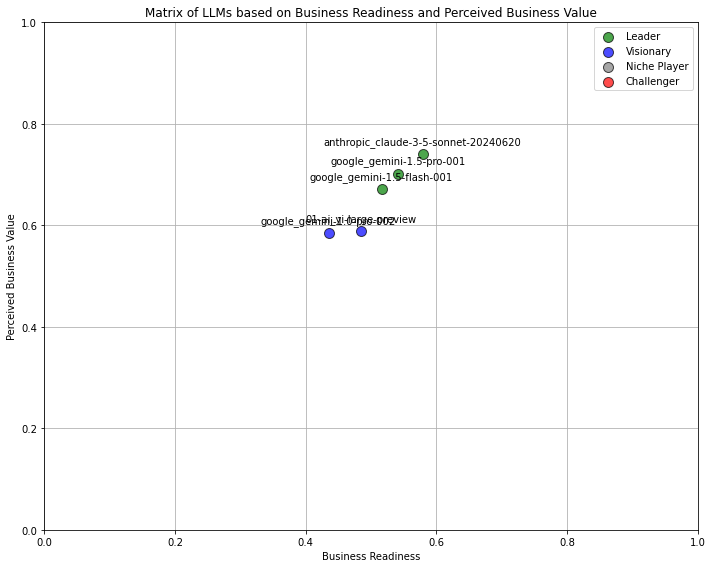

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load the JSON file
file_path = 'scores_v1.5.json'
with open(file_path, 'r') as file:
    data = json.load(file)

# Normalize the JSON into a DataFrame
df = pd.json_normalize(data, record_path=['tests'], meta=['model'])

# Define function to calculate the Business Readiness score
def calculate_business_readiness(row):
    accuracy_tests = {'exact_match', 'f1_score', 'quasi_exact_match', 'bleu_4'}
    benchmark_tests = {'commonsense', 'gsm', 'legalbench', 'math', 'med_qa', 'mmlu', 'natural_qa', 'wmt_14'}

    accuracy_score = []
    benchmark_score = []

    for subset in row['subsets']:
        if 'score' in subset:
            if subset['score'] is not None:
                if row['test_name'] in benchmark_tests and row['metric'] in accuracy_tests:
                    accuracy_score.append(subset['score'])
                if row['test_name'] in benchmark_tests:
                    benchmark_score.append(subset['score'])

    accuracy_avg = sum(accuracy_score) / len(accuracy_score) if accuracy_score else 0
    benchmark_avg = sum(benchmark_score) / len(benchmark_score) if benchmark_score else 0

    business_readiness = 0.4 * accuracy_avg + 0.6 * benchmark_avg
    return business_readiness

# Define function to calculate the Perceived Business Value score
def calculate_perceived_business_value(row):
    capabilities_score = []
    
    for subset in row['subsets']:
        if 'score' in subset:
            capabilities_score.append(subset['score'])
    
    capabilities_avg = sum(capabilities_score) / len(capabilities_score) if capabilities_score else 0
    return capabilities_avg

# Apply the functions to extract scores
df['Business Readiness'] = df.apply(calculate_business_readiness, axis=1)
df['Perceived Business Value'] = df.apply(calculate_perceived_business_value, axis=1)

# Aggregating scores for each LLM
agg_df = df.groupby('model').agg({
    'Business Readiness': 'mean',
    'Perceived Business Value': 'mean'
}).reset_index()

# Function to categorize quadrants
def categorize_quadrant(br_score, pbv_score, br_threshold, pbv_threshold):
    if br_score >= br_threshold and pbv_score >= pbv_threshold:
        return 'Leader'
    elif br_score < br_threshold and pbv_score >= pbv_threshold:
        return 'Visionary'
    elif br_score < br_threshold and pbv_score < pbv_threshold:
        return 'Niche Player'
    else:
        return 'Challenger'

# Define thresholds for categorization (you can adjust these as needed)
br_threshold = 0.5
pbv_threshold = 0.5

# Apply categorization to each row in the aggregated DataFrame
agg_df['Quadrant'] = agg_df.apply(lambda row: categorize_quadrant(row['Business Readiness'], row['Perceived Business Value'], br_threshold, pbv_threshold), axis=1)

# Define colors for each quadrant
colors = {'Leader': 'green', 'Visionary': 'blue', 'Niche Player': 'gray', 'Challenger': 'red'}

# Plotting
plt.figure(figsize=(10, 8))
for quadrant, color in colors.items():
    plt.scatter(agg_df[agg_df['Quadrant'] == quadrant]['Business Readiness'], agg_df[agg_df['Quadrant'] == quadrant]['Perceived Business Value'], 
                color=color, label=quadrant, alpha=0.7, s=100, edgecolor='k')  # Black edgecolor for points

# Annotate each point with LLM model name
for index, row in agg_df.iterrows():
    plt.annotate(row['model'], (row['Business Readiness'], row['Perceived Business Value']), textcoords="offset points", xytext=(0,10), ha='center')

# Add labels and title
plt.xlabel('Business Readiness')
plt.ylabel('Perceived Business Value')
plt.title('Matrix of LLMs based on Business Readiness and Perceived Business Value')

# Add legend
plt.legend()

# Set the limits for x and y axes to start at 0
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
agg_df

,model,Business Readiness,Perceived Business Value,Quadrant
0,01-ai_yi-large-preview,0.484511,0.588233,Visionary
1,anthropic_claude-3-5-sonnet-20240620,0.579403,0.740626,Leader
2,google_gemini-1.0-pro-002,0.435115,0.584332,Visionary
3,google_gemini-1.5-flash-001,0.516367,0.671693,Leader
4,google_gemini-1.5-pro-001,0.541280,0.702039,Leader


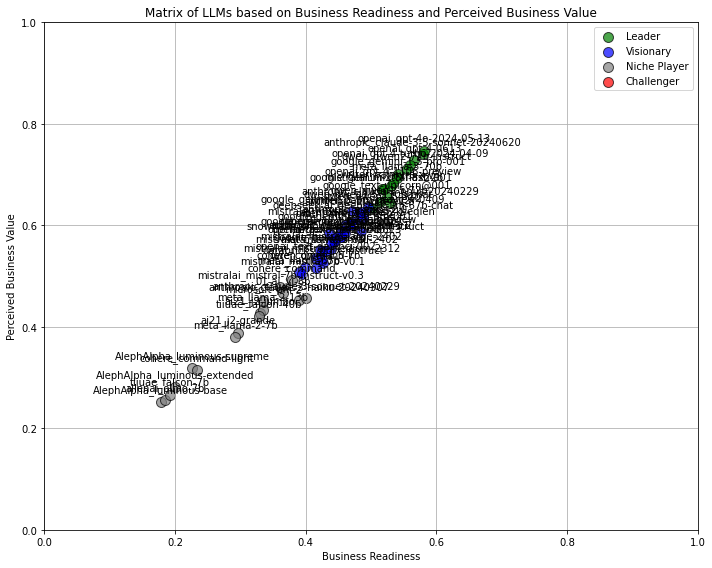

In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt

import json
import pandas as pd

# Files
files = ['scores_v1.0.0.json', 'scores_v1.1.0.json', 'scores_v1.2.0.json', 'scores_v1.3.0.json', 'scores_v1.4.0.json', 'scores_v1.5.0.json']

# Load the JSON files and collect data
all_data = []
for file_path in files:
    with open(file_path, 'r') as file:
        data = json.load(file)
        all_data.append(data)

# Check the structure of the first item in all_data to determine the structure
#print(json.dumps(all_data[0], indent=2))  # Pretty print for better readability

# Combine all data based on the structure observed
combined_tests = []
for data in all_data:
    if isinstance(data, dict) and "tests" in data:
        for test in data["tests"]:
            test["model"] = data["model"]
            combined_tests.append(test)
    elif isinstance(data, list):
        for item in data:
            if isinstance(item, dict) and "tests" in item:
                for test in item["tests"]:
                    test["model"] = item["model"]
                    combined_tests.append(test)
    else:
        print("Unexpected data structure:", data)

# Normalize the combined data into a DataFrame
df = pd.json_normalize(combined_tests)

# Define function to calculate the Business Readiness score
def calculate_business_readiness(row):
    accuracy_tests = {'exact_match', 'f1_score', 'quasi_exact_match', 'bleu_4'}
    benchmark_tests = {'commonsense', 'gsm', 'legalbench', 'math', 'med_qa', 'mmlu', 'natural_qa', 'wmt_14'}

    accuracy_score = []
    benchmark_score = []

    for subset in row['subsets']:
        if 'score' in subset:
            if subset['score'] is not None:
                if row['test_name'] in benchmark_tests and row['metric'] in accuracy_tests:
                    accuracy_score.append(subset['score'])
                if row['test_name'] in benchmark_tests:
                    benchmark_score.append(subset['score'])

    accuracy_avg = sum(accuracy_score) / len(accuracy_score) if accuracy_score else 0
    benchmark_avg = sum(benchmark_score) / len(benchmark_score) if benchmark_score else 0

    business_readiness = 0.4 * accuracy_avg + 0.6 * benchmark_avg
    return business_readiness

# Define function to calculate the Perceived Business Value score
def calculate_perceived_business_value(row):
    capabilities_score = []
    
    for subset in row['subsets']:
        if 'score' in subset:
            capabilities_score.append(subset['score'])
    
    capabilities_avg = sum(capabilities_score) / len(capabilities_score) if capabilities_score else 0
    return capabilities_avg

# Apply the functions to extract scores
df['Business Readiness'] = df.apply(calculate_business_readiness, axis=1)
df['Perceived Business Value'] = df.apply(calculate_perceived_business_value, axis=1)

# Aggregating scores for each LLM
agg_df = df.groupby('model').agg({
    'Business Readiness': 'mean',
    'Perceived Business Value': 'mean'
}).reset_index()

# Function to categorize quadrants
def categorize_quadrant(br_score, pbv_score, br_threshold, pbv_threshold):
    if br_score >= br_threshold and pbv_score >= pbv_threshold:
        return 'Leader'
    elif br_score < br_threshold and pbv_score >= pbv_threshold:
        return 'Visionary'
    elif br_score < br_threshold and pbv_score < pbv_threshold:
        return 'Niche Player'
    else:
        return 'Challenger'

# Define thresholds for categorization (you can adjust these as needed)
br_threshold = 0.5
pbv_threshold = 0.5

# Apply categorization to each row in the aggregated DataFrame
agg_df['Quadrant'] = agg_df.apply(lambda row: categorize_quadrant(row['Business Readiness'], row['Perceived Business Value'], br_threshold, pbv_threshold), axis=1)

# Define colors for each quadrant
colors = {'Leader': 'green', 'Visionary': 'blue', 'Niche Player': 'gray', 'Challenger': 'red'}

# Plotting
plt.figure(figsize=(10, 8))
for quadrant, color in colors.items():
    plt.scatter(agg_df[agg_df['Quadrant'] == quadrant]['Business Readiness'], agg_df[agg_df['Quadrant'] == quadrant]['Perceived Business Value'], 
                color=color, label=quadrant, alpha=0.7, s=100, edgecolor='k')  # Black edgecolor for points

# Annotate each point with LLM model name
for index, row in agg_df.iterrows():
    plt.annotate(row['model'], (row['Business Readiness'], row['Perceived Business Value']), textcoords="offset points", xytext=(0,10), ha='center')

# Add labels and title
plt.xlabel('Business Readiness')
plt.ylabel('Perceived Business Value')
plt.title('Matrix of LLMs based on Business Readiness and Perceived Business Value')

# Add legend
plt.legend()

# Set the limits for x and y axes to start at 0
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
pip install plotly

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/b8/f0/bcf716a8e070370d6598c92fcd328bd9ef8a9bda2c5562da5a835c66700b/plotly-5.23.0-py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/d2/3f/8ba87d9e287b9d385a02a7114ddcef61b26f86411e121c9003eb509a1773/tenacity-8.5.0-py3-none-any.whl.metadata


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 17.3/17.3 MB 11.9 MB/s eta 0:00:00


In [8]:
import json
import pandas as pd
import plotly.express as px

# Files
files = ['scores_v1.0.0.json', 'scores_v1.1.0.json', 'scores_v1.2.0.json', 'scores_v1.3.0.json', 'scores_v1.4.0.json', 'scores_v1.5.0.json']

# Load the JSON files and collect data
all_data = []
for file_path in files:
    with open(file_path, 'r') as file:
        data = json.load(file)
        all_data.append(data)

# Combine all data based on the structure observed
combined_tests = []
for data in all_data:
    if isinstance(data, dict) and "tests" in data:
        for test in data["tests"]:
            test["model"] = data["model"]
            combined_tests.append(test)
    elif isinstance(data, list):
        for item in data:
            if isinstance(item, dict) and "tests" in item:
                for test in item["tests"]:
                    test["model"] = item["model"]
                    combined_tests.append(test)
    else:
        print("Unexpected data structure:", data)

# Normalize the combined data into a DataFrame
df = pd.json_normalize(combined_tests)

# Define function to calculate the Business Readiness score
def calculate_business_readiness(row):
    accuracy_tests = {'exact_match', 'f1_score', 'quasi_exact_match', 'bleu_4'}
    benchmark_tests = {'commonsense', 'gsm', 'legalbench', 'math', 'med_qa', 'mmlu', 'natural_qa', 'wmt_14'}

    accuracy_score = []
    benchmark_score = []

    for subset in row['subsets']:
        if 'score' in subset:
            if subset['score'] is not None:
                if row['test_name'] in benchmark_tests and row['metric'] in accuracy_tests:
                    accuracy_score.append(subset['score'])
                if row['test_name'] in benchmark_tests:
                    benchmark_score.append(subset['score'])

    accuracy_avg = sum(accuracy_score) / len(accuracy_score) if accuracy_score else 0
    benchmark_avg = sum(benchmark_score) / len(benchmark_score) if benchmark_score else 0

    business_readiness = 0.4 * accuracy_avg + 0.6 * benchmark_avg
    return business_readiness

# Define function to calculate the Perceived Business Value score
def calculate_perceived_business_value(row):
    capabilities_score = []
    
    for subset in row['subsets']:
        if 'score' in subset:
            capabilities_score.append(subset['score'])
    
    capabilities_avg = sum(capabilities_score) / len(capabilities_score) if capabilities_score else 0
    return capabilities_avg

# Apply the functions to extract scores
df['Business Readiness'] = df.apply(calculate_business_readiness, axis=1)
df['Perceived Business Value'] = df.apply(calculate_perceived_business_value, axis=1)

# Aggregating scores for each LLM
agg_df = df.groupby('model').agg({
    'Business Readiness': 'mean',
    'Perceived Business Value': 'mean'
}).reset_index()

# Function to categorize quadrants
def categorize_quadrant(br_score, pbv_score, br_threshold, pbv_threshold):
    if br_score >= br_threshold and pbv_score >= pbv_threshold:
        return 'Leader'
    elif br_score < br_threshold and pbv_score >= pbv_threshold:
        return 'Visionary'
    elif br_score < br_threshold and pbv_score < pbv_threshold:
        return 'Niche Player'
    else:
        return 'Challenger'

# Define thresholds for categorization (you can adjust these as needed)
br_threshold = 0.5
pbv_threshold = 0.5

# Apply categorization to each row in the aggregated DataFrame
agg_df['Quadrant'] = agg_df.apply(lambda row: categorize_quadrant(row['Business Readiness'], row['Perceived Business Value'], br_threshold, pbv_threshold), axis=1)

# Define colors for each quadrant
colors = {'Leader': 'green', 'Visionary': 'blue', 'Niche Player': 'gray', 'Challenger': 'red'}

# Plotting with Plotly
fig = px.scatter(
    agg_df,
    x='Business Readiness',
    y='Perceived Business Value',
    color='Quadrant',
    hover_data=['model'],
    text='model',
    color_discrete_map=colors,
    labels={
        'Business Readiness': 'Business Readiness',
        'Perceived Business Value': 'Perceived Business Value'
    },
    title='Matrix of LLMs based on Business Readiness and Perceived Business Value'
)

# Customize the layout for better readability
fig.update_traces(textposition='top center')
fig.update_layout(
    legend_title_text='Quadrant',
    xaxis=dict(range=[0, 1], title='Business Readiness'),
    yaxis=dict(range=[0, 1], title='Perceived Business Value'),
    template='plotly_white'
)

# Show plot
fig.show()
